# Task 6: Music Genre Classification
In this notebook, we classify music genres using the GTZAN dataset.  
We will try both **tabular features (MFCCs etc.)** and **image-based spectrograms with CNNs**, and compare results.

## 1. Setup & Libraries
We install and import the required Python libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import librosa
import tensorflow
import keras
from pydub import AudioSegment
from keras import models,layers,utils
from PIL import Image
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

C:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## 2. Load Dataset (Tabular Features)
- We use the `features_30_sec.csv` file which contains pre-extracted features from GTZAN.


In [2]:
df = pd.read_csv(r"C:\Users\Administrator\AppData\Local\Programs\Python\Python313\Scripts\data\features_30_sec.csv")
df.head()



,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


## 3. Preprocessing 


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

In [4]:
df.describe()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,662030.846000,0.378682,0.086340,0.130930,0.003051,2201.780898,4.696916e+05,2242.541070,137079.155165,4571.549304,...,1.148144,60.730958,-3.966028,62.633624,0.507696,63.712586,-2.328761,66.231930,-1.095348,70.126096
std,1784.073992,0.081705,0.007735,0.065683,0.003634,715.960600,4.008995e+05,526.316473,96455.666326,1574.791602,...,4.578948,33.781951,4.549697,33.479172,3.869105,34.401977,3.755957,37.174631,3.837007,45.228512
min,660000.000000,0.171939,0.044555,0.005276,0.000004,570.040355,7.911251e+03,898.066208,10787.185064,749.140636,...,-15.693844,9.169314,-17.234728,13.931521,-11.963694,15.420555,-18.501955,13.487622,-19.929634,7.956583
25%,661504.000000,0.319562,0.082298,0.086657,0.000942,1627.697311,1.843505e+05,1907.240605,67376.554428,3380.069642,...,-1.863280,40.376442,-7.207225,40.830875,-2.007015,41.884240,-4.662925,41.710184,-3.368996,42.372865
50%,661794.000000,0.383148,0.086615,0.122443,0.001816,2209.263090,3.384862e+05,2221.392843,111977.548036,4658.524473,...,1.212809,52.325077,-4.065605,54.717674,0.669643,54.804890,-2.393862,57.423059,-1.166289,59.186117
75%,661794.000000,0.435942,0.091256,0.175682,0.003577,2691.294667,6.121479e+05,2578.469836,182371.576801,5533.810460,...,4.359662,71.691755,-0.838737,75.040838,3.119212,75.385832,0.150573,78.626444,1.312615,85.375374
max,675808.000000,0.663685,0.108111,0.397973,0.027679,4435.243901,3.036843e+06,3509.646417,694784.811549,8677.672688,...,13.457150,392.932373,11.482946,406.058868,15.388390,332.905426,14.694924,393.161987,15.369627,506.065155


## 4. Tabular Feature-Based Classification (Random Forest / Other ML Models)
- We train models like Random Forest on extracted audio features.


In [5]:

x=df.drop(['label', 'filename'],axis=1)
y=df['label']

In [6]:
print(x.shape)
print(y.shape)

(1000, 58)
(1000,)


In [7]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
     

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
     

(800, 58)
(200, 58)
(800,)
(200,)


In [8]:

rf_model=RandomForestClassifier(n_estimators=100)
rf_model.fit(x_train,y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [9]:
rf_model.score(x_train,y_train)
     

0.99875

In [10]:
rf_model.score(x_test,y_test)

0.79

In [11]:
y_pred=rf_model.predict(x_test)
print(y_pred)

['jazz' 'pop' 'pop' 'metal' 'hiphop' 'metal' 'metal' 'jazz' 'reggae'
 'classical' 'reggae' 'blues' 'metal' 'rock' 'pop' 'metal' 'rock' 'reggae'
 'pop' 'hiphop' 'country' 'classical' 'disco' 'jazz' 'country' 'country'
 'classical' 'rock' 'hiphop' 'disco' 'disco' 'classical' 'metal' 'hiphop'
 'metal' 'classical' 'metal' 'jazz' 'rock' 'blues' 'disco' 'blues' 'disco'
 'rock' 'blues' 'country' 'rock' 'metal' 'hiphop' 'reggae' 'jazz' 'reggae'
 'blues' 'jazz' 'blues' 'blues' 'metal' 'blues' 'country' 'reggae'
 'country' 'metal' 'jazz' 'country' 'metal' 'disco' 'metal' 'reggae'
 'rock' 'jazz' 'classical' 'hiphop' 'jazz' 'reggae' 'rock' 'country'
 'metal' 'blues' 'jazz' 'disco' 'metal' 'blues' 'blues' 'blues' 'disco'
 'jazz' 'country' 'reggae' 'pop' 'hiphop' 'disco' 'hiphop' 'jazz'
 'country' 'pop' 'hiphop' 'pop' 'blues' 'blues' 'reggae' 'pop' 'metal'
 'rock' 'country' 'metal' 'metal' 'jazz' 'rock' 'classical' 'rock' 'jazz'
 'hiphop' 'rock' 'blues' 'blues' 'reggae' 'classical' 'rock' 'jazz'
 'c

In [12]:

print(y_test)
print(y_pred)

521       jazz
737        pop
740        pop
660      metal
411     hiphop
        ...   
408     hiphop
332      disco
208    country
613      metal
78       blues
Name: label, Length: 200, dtype: object
['jazz' 'pop' 'pop' 'metal' 'hiphop' 'metal' 'metal' 'jazz' 'reggae'
 'classical' 'reggae' 'blues' 'metal' 'rock' 'pop' 'metal' 'rock' 'reggae'
 'pop' 'hiphop' 'country' 'classical' 'disco' 'jazz' 'country' 'country'
 'classical' 'rock' 'hiphop' 'disco' 'disco' 'classical' 'metal' 'hiphop'
 'metal' 'classical' 'metal' 'jazz' 'rock' 'blues' 'disco' 'blues' 'disco'
 'rock' 'blues' 'country' 'rock' 'metal' 'hiphop' 'reggae' 'jazz' 'reggae'
 'blues' 'jazz' 'blues' 'blues' 'metal' 'blues' 'country' 'reggae'
 'country' 'metal' 'jazz' 'country' 'metal' 'disco' 'metal' 'reggae'
 'rock' 'jazz' 'classical' 'hiphop' 'jazz' 'reggae' 'rock' 'country'
 'metal' 'blues' 'jazz' 'disco' 'metal' 'blues' 'blues' 'blues' 'disco'
 'jazz' 'country' 'reggae' 'pop' 'hiphop' 'disco' 'hiphop' 'jazz'
 'country' 

In [13]:
     
print(accuracy_score(y_test,y_pred))

0.79


In [14]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       blues       0.68      0.85      0.76        20
   classical       1.00      1.00      1.00        13
     country       0.82      0.67      0.73        27
       disco       0.74      0.67      0.70        21
      hiphop       0.62      0.87      0.72        15
        jazz       1.00      0.91      0.95        22
       metal       0.85      0.92      0.88        25
         pop       0.83      0.77      0.80        13
      reggae       0.76      0.70      0.73        23
        rock       0.70      0.67      0.68        21

    accuracy                           0.79       200
   macro avg       0.80      0.80      0.80       200
weighted avg       0.80      0.79      0.79       200



In [15]:

cm=confusion_matrix(y_test,y_pred)
print(cm)

[[17  0  0  0  0  0  1  0  0  2]
 [ 0 13  0  0  0  0  0  0  0  0]
 [ 6  0 18  0  0  0  0  0  0  3]
 [ 0  0  0 14  4  0  2  1  0  0]
 [ 0  0  0  1 13  0  0  0  1  0]
 [ 0  0  1  0  0 20  0  0  0  1]
 [ 0  0  0  2  0  0 23  0  0  0]
 [ 0  0  0  0  0  0  0 10  3  0]
 [ 2  0  1  0  3  0  1  0 16  0]
 [ 0  0  2  2  1  0  0  1  1 14]]


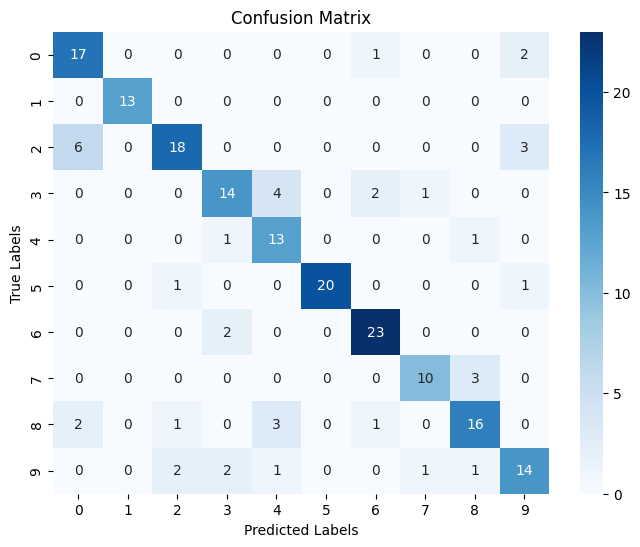

In [16]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
     

In [18]:

print(rf_model.feature_importances_)

[0.04193995 0.0424451  0.02546774 0.02916582 0.02804724 0.02213676
 0.02646061 0.02559242 0.01327625 0.02497649 0.0198943  0.01746492
 0.01477968 0.01322152 0.0217506  0.01706437 0.04684198 0.00865155
 0.02254692 0.01115164 0.01371134 0.00973174 0.01436989 0.01451928
 0.02887055 0.01597827 0.01216067 0.02436967 0.01946386 0.01556404
 0.01589685 0.0177908  0.02097129 0.01372255 0.02336639 0.00986888
 0.01157347 0.01311457 0.01485744 0.01166118 0.01939468 0.00930449
 0.01403622 0.01088354 0.01235843 0.00919756 0.01027082 0.00626866
 0.01245755 0.00807025 0.01521861 0.00983853 0.00909172 0.01008814
 0.00942748 0.01359034 0.00967044 0.01639395]


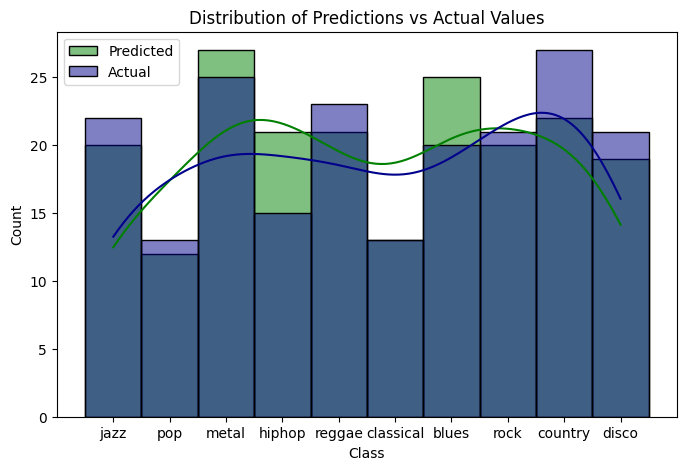

In [46]:
plt.figure(figsize=(8, 5))
sns.histplot(y_pred, color='green', label="Predicted", alpha=0.5, bins=10, kde=True)
sns.histplot(y_test, color='darkblue', label="Actual", alpha=0.5, bins=10, kde=True)

plt.legend()
plt.title("Distribution of Predictions vs Actual Values")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


## 5. Spectrogram Generation
We generate Mel-Spectrograms for each audio file, which will be used to train a CNN.

In [21]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os

data_dir = r"C:\Users\Administrator\AppData\Local\Programs\Python\Python313\Scripts\data\genres_original"
spectrogram_dir = r"C:\Users\Administrator\AppData\Local\Programs\Python\Python313\Scripts\data\spectrogram_data"

os.makedirs(spectrogram_dir, exist_ok=True)


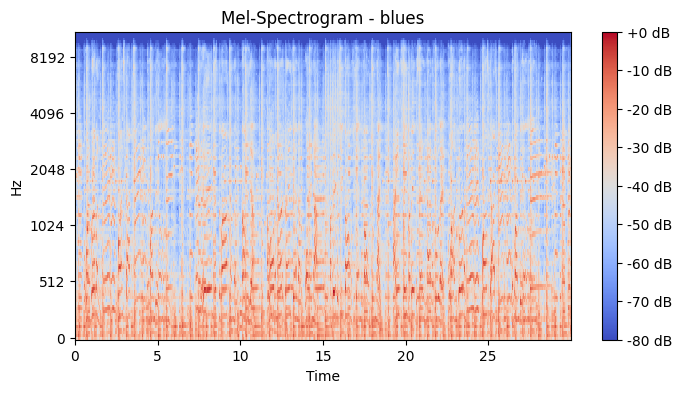

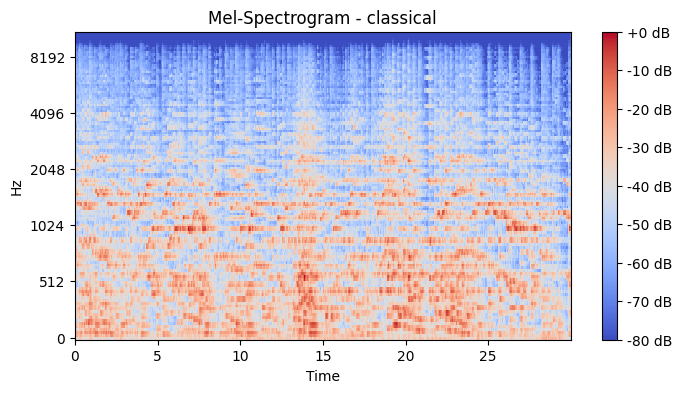

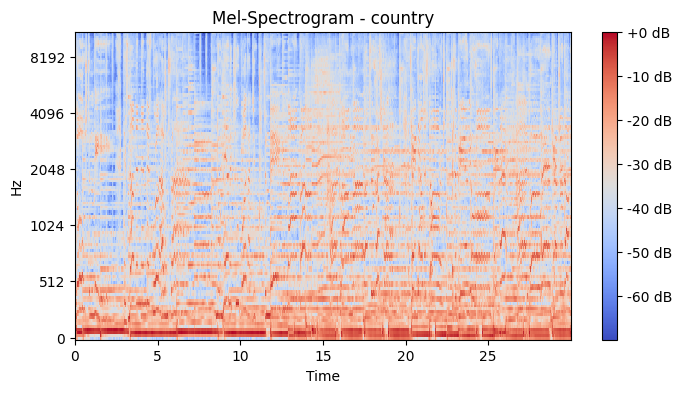

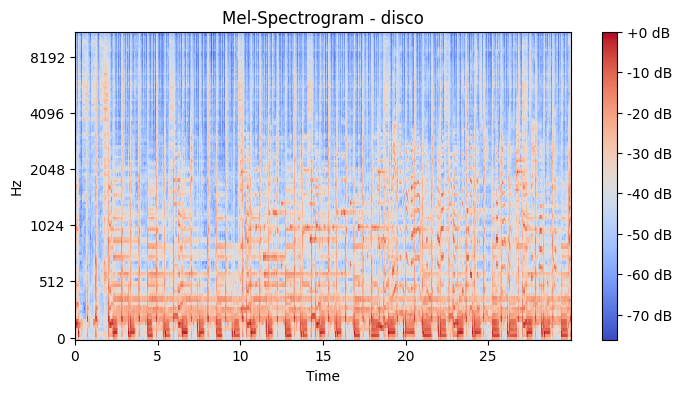

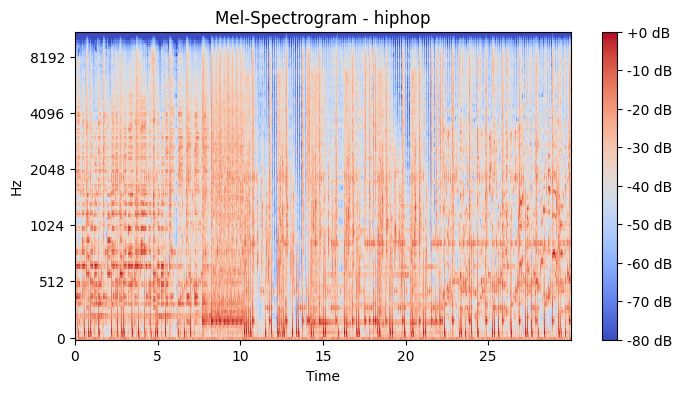

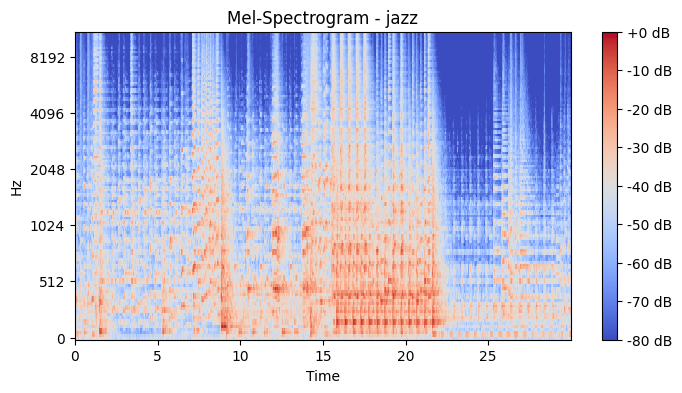

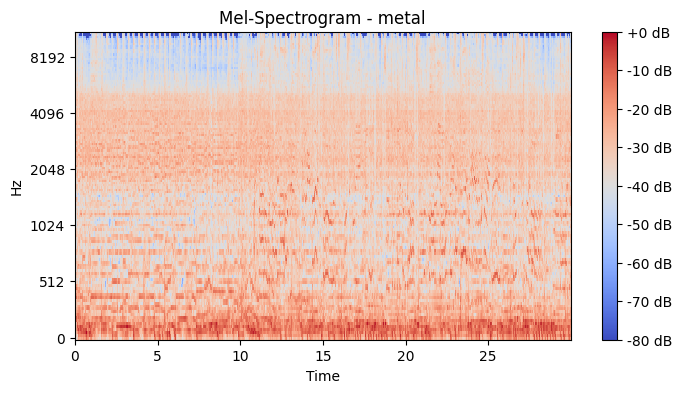

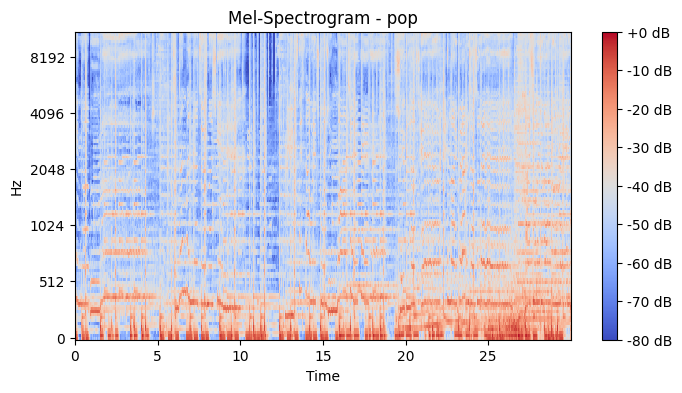

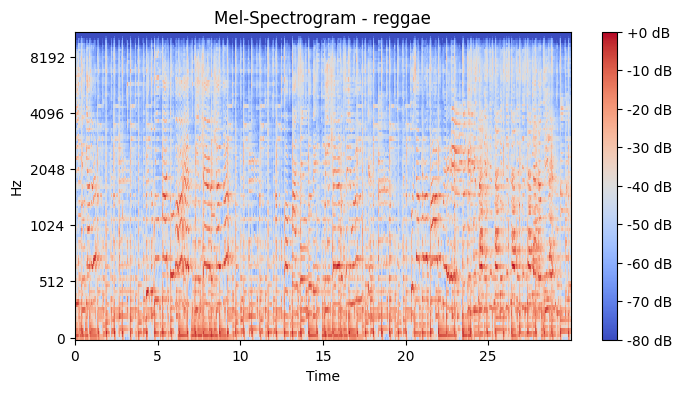

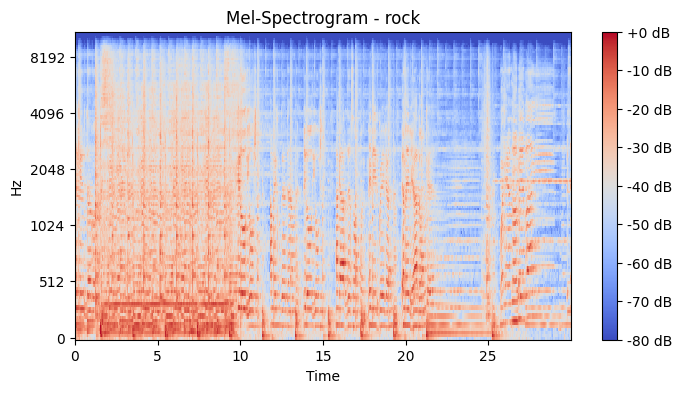

In [35]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os

# Enable inline plots in Jupyter
%matplotlib inline  

# Path to your dataset
data_dir = r"C:\Users\Administrator\AppData\Local\Programs\Python\Python313\Scripts\data\genres_original"

# Show spectrograms for one example file per genre
for genre in os.listdir(data_dir):
    genre_path = os.path.join(data_dir, genre)
    for file in os.listdir(genre_path):
        if file.endswith(".wav"):
            file_path = os.path.join(genre_path, file)

            # Load audio
            y, sr = librosa.load(file_path, sr=22050, duration=30, mono=True)

            # Create mel spectrogram
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
            S_DB = librosa.power_to_db(S, ref=np.max)

            # Plot
            plt.figure(figsize=(8, 4))
            librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel', cmap="coolwarm")
            plt.colorbar(format='%+2.0f dB')
            plt.title(f"Mel-Spectrogram - {genre}")
            plt.show()
            plt.close()   

            break  # only show one sample per genre


## 6. CNN Model on Spectrograms
We now train a Convolutional Neural Network (CNN) on spectrogram images.

In [48]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to spectrogram images
img_height, img_width = 64 , 64
batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    spectrogram_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    spectrogram_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Build CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height,img_width,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, validation_data=val_generator, epochs=10)


Found 800 images belonging to 10 classes.
Found 199 images belonging to 10 classes.


C:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - accuracy: 0.1775 - loss: 2.2077 - val_accuracy: 0.2563 - val_loss: 2.0143
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.3250 - loss: 1.8766 - val_accuracy: 0.2663 - val_loss: 2.0164
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.4288 - loss: 1.5851 - val_accuracy: 0.3467 - val_loss: 1.6552
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.5300 - loss: 1.3549 - val_accuracy: 0.4673 - val_loss: 1.5713
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.6050 - loss: 1.1687 - val_accuracy: 0.4472 - val_loss: 1.5887
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.6737 - loss: 0.9560 - val_accuracy: 0.4975 - val_loss: 1.5797
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 0.7225 - loss: 0.7795 - val_accuracy: 0.4573 - val_loss: 1.6931
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.7663 - loss: 0.7011 - val_accuracy: 0.5

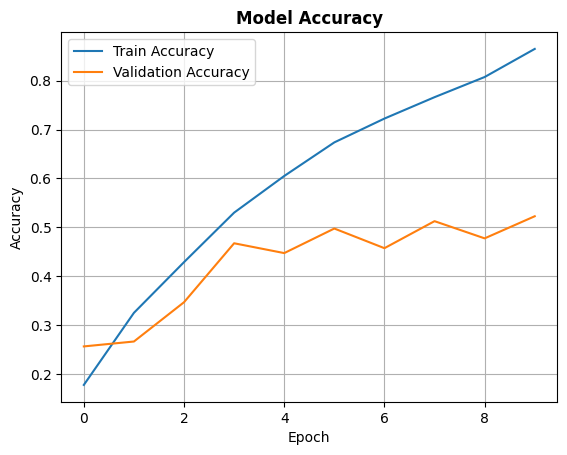

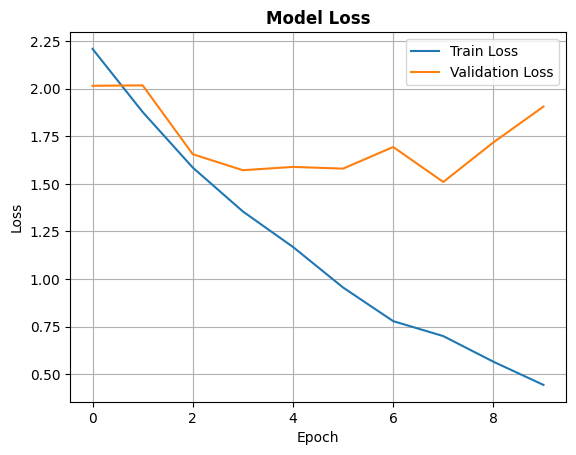

In [52]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy', fontweight="bold")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss',fontweight="bold")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


In [47]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to spectrogram images
img_height, img_width = 64, 64   # smaller size = less computation
batch_size = 16                  # smaller batch = lighter on RAM/CPU

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    spectrogram_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    spectrogram_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Build a lighter CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train fewer epochs to avoid overheating
history = model.fit(train_generator, validation_data=val_generator, epochs=3)


Found 800 images belonging to 10 classes.
Found 199 images belonging to 10 classes.
Epoch 1/3


C:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.1550 - loss: 2.2647 - val_accuracy: 0.1960 - val_loss: 2.1314
Epoch 2/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.2163 - loss: 2.0695 - val_accuracy: 0.2111 - val_loss: 2.0871
Epoch 3/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.3013 - loss: 1.8915 - val_accuracy: 0.2915 - val_loss: 1.9381


## 7. Comparison of Approaches
We compare the accuracy of:
1. Tabular model (Random Forest)  
2. CNN on spectrogram images  


In [53]:
print("Random Forest Accuracy:", rf_model.score(x_test, y_test))
print("CNN Validation Accuracy:", history.history['val_accuracy'][-1])


Random Forest Accuracy: 0.79
CNN Validation Accuracy: 0.5226130485534668


## 8. Bonus: Transfer Learning (VGG16)
We use a pretrained CNN (VGG16) on spectrograms for better performance.


In [56]:
# Dataset path
DATASET_PATH = r"C:\Users\Administrator\AppData\Local\Programs\Python\Python313\Scripts\genres_original"

# List of all genres (folders inside genres_original)
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
          'jazz', 'metal', 'pop', 'reggae', 'rock']


In [59]:
IMG_SIZE = (64, 64)
os.makedirs("spectrograms", exist_ok=True)

def audio_to_spectrogram(file_path, save_path):
    try:
        y, sr = librosa.load(file_path, duration=30)
        S = librosa.feature.melspectrogram(y=y, sr=sr)
        S_DB = librosa.power_to_db(S, ref=np.max)
        plt.figure(figsize=(2, 2))
        librosa.display.specshow(S_DB, sr=sr)
        plt.axis('off')
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        plt.close()
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None


for genre in genres:
    save_dir = os.path.join("spectrograms", genre)
    os.makedirs(save_dir, exist_ok=True)
    genre_path = os.path.join(DATASET_PATH, genre)
    for file in os.listdir(genre_path):
        if file.endswith(".wav"):
            file_path = os.path.join(genre_path, file)
            save_path = os.path.join(save_dir, file.replace(".wav", ".png"))
            if not os.path.exists(save_path):
                audio_to_spectrogram(file_path, save_path)


from PIL import Image
X_img, y_img = [], []
for i, genre in enumerate(genres):
    genre_path = os.path.join("spectrograms", genre)
    for file in os.listdir(genre_path):
        img_path = os.path.join(genre_path, file)
        try:
            img = Image.open(img_path).convert('RGB').resize(IMG_SIZE) # Convert to RGB
            X_img.append(np.array(img))
            y_img.append(i)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")


X_img = np.array(X_img) / 255.0
y_img = to_categorical(y_img, num_classes=len(genres))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15284\1149083648.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, duration=30)


Error processing file C:\Users\Administrator\AppData\Local\Programs\Python\Python313\Scripts\genres_original\jazz\jazz.00054.wav: 


In [60]:
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(X_img, y_img, test_size=0.2, random_state=42)
     


In [61]:
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(X_img, y_img, test_size=0.2, random_state=42)
     

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(genres), activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_img, y_train_img, epochs=5, validation_data=(X_test_img, y_test_img))

C:\Users\Administrator\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.1827 - loss: 2.2116 - val_accuracy: 0.1800 - val_loss: 2.1776
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.2891 - loss: 1.9648 - val_accuracy: 0.3250 - val_loss: 1.8741
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.3930 - loss: 1.7445 - val_accuracy: 0.3850 - val_loss: 1.7686
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.4318 - loss: 1.5987 - val_accuracy: 0.2950 - val_loss: 1.8850
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.4255 - loss: 1.5276 - val_accuracy: 0.3750 - val_loss: 1.6585


In [62]:

print(cnn_model.summary())
     

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │         802,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,468,768 (9.42 MB)

 Trainable params: 822,922 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,645,846 (6.28 MB)

None


In [63]:
print(classification_report(np.argmax(y_test_img, axis=1), np.argmax(cnn_model.predict(X_test_img), axis=1)))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
              precision    recall  f1-score   support

           0       0.28      0.33      0.30        21
           1       0.26      0.83      0.40        12
           2       0.67      0.08      0.15        24
           3       1.00      0.14      0.24        22
           4       0.21      0.47      0.29        15
           5       0.31      0.19      0.23        27
           6       0.45      0.83      0.59        18
           7       0.52      0.58      0.55        19
           8       0.82      0.41      0.55        22
           9       0.35      0.30      0.32        20

    accuracy                           0.38       200
   macro avg       0.49      0.42      0.36       200
weighted avg       0.51      0.38      0.35       200



In [64]:

print(accuracy_score(np.argmax(y_test_img, axis=1), np.argmax(cnn_model.predict(X_test_img), axis=1)))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0.375


In [65]:

cm=confusion_matrix(np.argmax(y_test_img, axis=1), np.argmax(cnn_model.predict(X_test_img), axis=1))
print(cm)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[ 7  6  0  0  1  0  7  0  0  0]
 [ 0 10  0  0  0  1  0  0  0  1]
 [ 2  4  2  0  3  6  1  0  0  6]
 [ 1  0  0  3  5  0  5  5  1  2]
 [ 4  0  0  0  7  0  1  2  1  0]
 [ 3 14  0  0  4  5  1  0  0  0]
 [ 1  0  0  0  1  1 15  0  0  0]
 [ 0  2  1  0  3  0  0 11  0  2]
 [ 1  2  0  0  6  1  1  2  9  0]
 [ 6  0  0  0  3  2  2  1  0  6]]


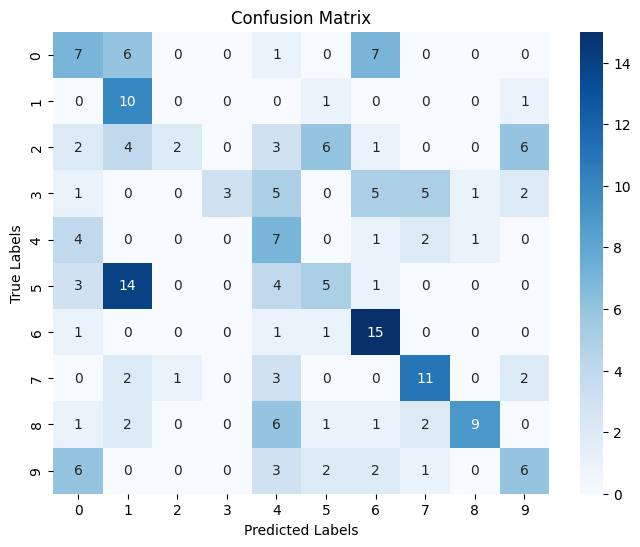

In [66]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
     


In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(y_pred, color='green', label="Predicted", alpha=0.5, bins=10, kde=True)
sns.histplot(y_test, color='darkblue', label="Actual", alpha=0.5, bins=10, kde=True)

plt.legend()
plt.title("Distribution of Predictions vs Actual Values")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## 9. Trasfer Learning

In [ ]:
IMG_SIZE_VGG = (64, 64)
X_vgg, y_vgg = [], []
for i, genre in enumerate(genres):
    genre_path = os.path.join("spectrograms", genre)
    for file in os.listdir(genre_path):
        img_path = os.path.join(genre_path, file)
        try:
            img = Image.open(img_path).convert('RGB').resize(IMG_SIZE_VGG) # Convert to RGB
            X_vgg.append(np.array(img))
            y_vgg.append(i)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")


X_vgg = np.array(X_vgg) / 255.0
y_vgg = to_categorical(y_vgg, num_classes=len(genres))

X_train_vgg, X_test_vgg, y_train_vgg, y_test_vgg = train_test_split(X_vgg, y_vgg, test_size=0.2, random_state=42)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE_VGG[0], IMG_SIZE_VGG[1], 3))
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(genres), activation='softmax')(x)

vgg_model = Model(inputs=base_model.input, outputs=output)
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model.fit(X_train_vgg, y_train_vgg, epochs=1, validation_data=(X_test_vgg, y_test_vgg))

40828928/58889256 ━━━━━━━━━━━━━━━━━━━━ 1:40 6us/step

In [ ]:
print(classification_report(np.argmax(y_test_vgg, axis=1), np.argmax(vgg_model.predict(X_test_vgg), axis=1)))

In [ ]:
print(accuracy_score(np.argmax(y_test_vgg, axis=1), np.argmax(vgg_model.predict(X_test_vgg), axis=1)))

In [ ]:
print(vgg_model.summary())

In [ ]:

!apt-get install ffmpeg

## 9. Save data file

In [ ]:
import joblib
joblib.dump(vgg_model, 'task7_Sales_Forecasting.pkl')
import os
print(os.getcwd())